In [1]:
# Standard Libs
import os
import math
import numpy as np

# ploting libs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm.notebook import  tqdm

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

import pytorch_lightning as pl

path = "data"
model_path = "models/arg_model"

pl.seed_everything(36)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


Seed set to 36


cpu


In [29]:
def discretize(sample):
    return (sample * 255).to(torch.long)

transform = transforms.Compose([
    transforms.ToTensor(),
    discretize
])

train_dataset = MNIST(root=path,train=True,transform=transform,download=True)

train_set,val_set = torch.utils.data.random_split(train_dataset,[50000,10000])

test_set = MNIST(root=path,train=False,transform=transform,download=True)

train_loader = data.DataLoader(train_set,batch_size=64,shuffle=True,drop_last=True)
val_loader = data.DataLoader(val_set,batch_size=64,shuffle=False,drop_last=False)
test_loader = data.DataLoader(test_set,batch_size=64,shuffle=False,drop_last=False)

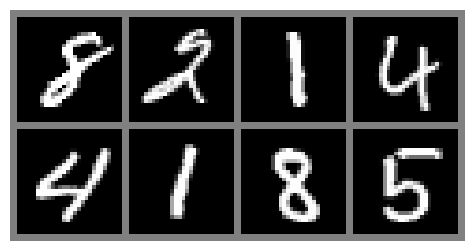

In [30]:
def show_imgs(imgs):
    num_imgs = imgs.shape[0] if isinstance(imgs,torch.Tensor) else len(imgs)
    
    nrow = min(num_imgs,4)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs,nrow=nrow,pad_value=128)
    imgs = imgs.clamp(min=0,max=255)
    
    np_imgs = imgs.cpu().numpy()
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs,(1,2,0)),interpolation="nearest")
    plt.axis("off")
    plt.show()
    plt.close()
    
show_imgs([train_set[i][0] for i in range(8)])

In [31]:
class MaskedConvolution(nn.Module):
    def __init__(self,c_in,c_out,mask,**kwargs):
        super().__init__()
        
        kernel_size = (mask.shape[0],mask.shape[1])
        dilation = 1 if "dilation" not in kwargs else kwargs["dilation"]
        padding = tuple([dilation*(kernel_size[i]-1)//2 for i in range(2)])
        
        self.conv = nn.Conv2d(c_in,c_out,kernel_size,padding=padding,**kwargs)
        
        self.register_buffer('mask',mask[None,None])
        
    def forward(self,x):
        self.conv.weight.data *= self.mask
        return self.conv(x)

In [32]:
class VerticalStackConvolution(MaskedConvolution):
    def __init__(self,c_in,c_out,kernel_size=3,mask_center=False,**kwargs):
        mask = torch.ones(kernel_size,kernel_size)
        mask[kernel_size//2+1:,:] = 0
        if mask_center:
            mask[kernel_size//2,:]=0
            
        super().__init__(c_in,c_out,mask,**kwargs)
        
class HorizontalStackConvolution(MaskedConvolution):
    def __init__(self,c_in,c_out,kernel_size=3,mask_center=False,**kwargs):
        mask = torch.ones(1,kernel_size)
        mask[0,kernel_size//2+1:] = 0
        if mask_center:
            mask[0,kernel_size//2]=0
            
        super().__init__(c_in,c_out,mask,**kwargs)

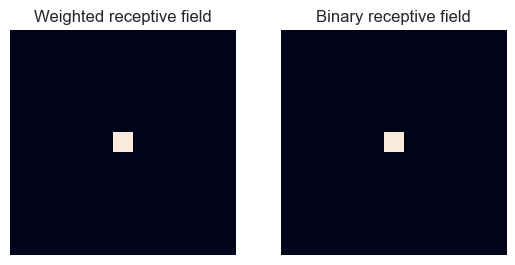

In [33]:
inp_img = torch.zeros(1,1,11,11)
inp_img.requires_grad_()

def show_center_recep_field(img,out):
    loss = out[0,:,img.shape[2]//2,img.shape[3]//2].sum() #l1 loss
    loss.backward(retain_graph=True)
    
    img_grads = img.grad.abs()
    img.grad.fill_(0) 
    
    img = img_grads.squeeze().cpu().numpy()
    fig,ax = plt.subplots(1,2)
    pos = ax[0].imshow(img)
    ax[1].imshow(img>0)
    
    show_center = (img[img.shape[0]//2,img.shape[1]//2]==0)
    
    if show_center:
        center_pixel = np.zeros(img.shape + (4,))
        center_pixel[center_pixel.shape[0]//2,center_pixel.shape[1]//2,:] = np.array([1.0, 0.0, 0.0, 1.0])

    for i in range(2):
        ax[i].axis('off')
        if show_center:
            ax[i].imshow(center_pixel)
    ax[0].set_title("Weighted receptive field")
    ax[1].set_title("Binary receptive field")
    plt.show()
    plt.close()
    
show_center_recep_field(inp_img, inp_img)


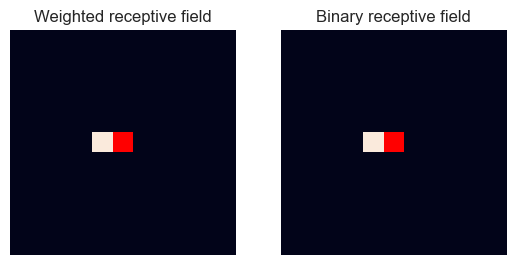

In [34]:
horiz_conv = HorizontalStackConvolution(c_in=1, c_out=1, kernel_size=3, mask_center=True)
horiz_conv.conv.weight.data.fill_(1)
horiz_conv.conv.bias.data.fill_(0)
horiz_img = horiz_conv(inp_img)
show_center_recep_field(inp_img, horiz_img)

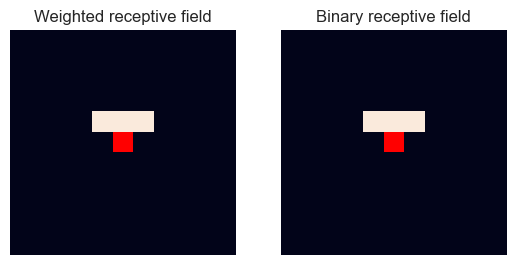

In [35]:
vert_conv = VerticalStackConvolution(c_in=1, c_out=1, kernel_size=3, mask_center=True)
vert_conv.conv.weight.data.fill_(1)
vert_conv.conv.bias.data.fill_(0)
vert_img = vert_conv(inp_img)
show_center_recep_field(inp_img, vert_img)

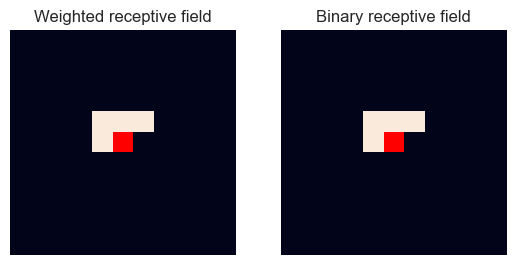

In [36]:
horiz_img = vert_img + horiz_img
show_center_recep_field(inp_img, horiz_img)

Layer 2


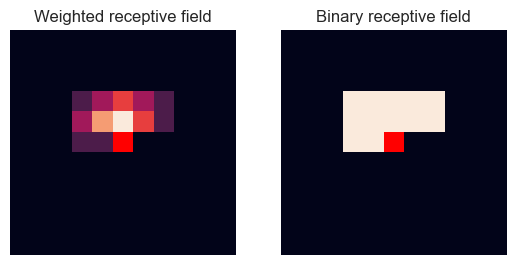

Layer 3


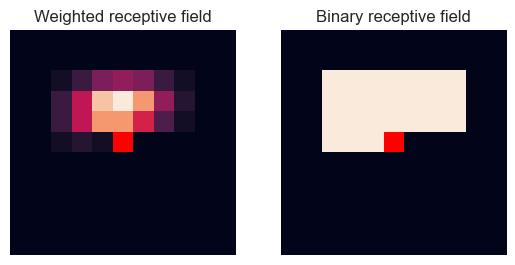

Layer 4


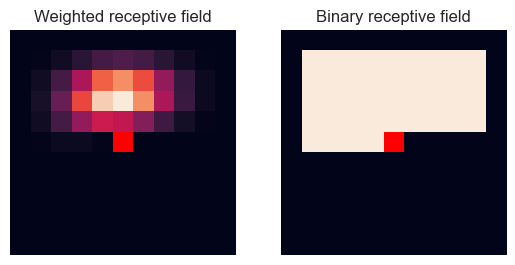

Layer 5


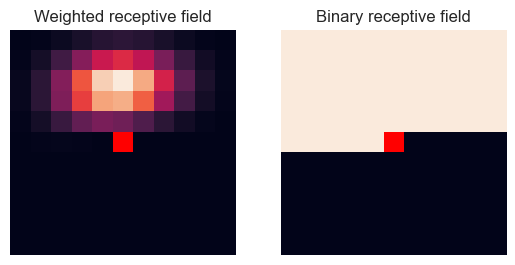

In [37]:
horiz_conv = HorizontalStackConvolution(c_in=1, c_out=1, kernel_size=3, mask_center=False)
horiz_conv.conv.weight.data.fill_(1)
horiz_conv.conv.bias.data.fill_(0)
vert_conv = VerticalStackConvolution(c_in=1, c_out=1, kernel_size=3,mask_center=False)
vert_conv.conv.weight.data.fill_(1)
vert_conv.conv.bias.data.fill_(0)


for l_idx in range(4):
    vert_img = vert_conv(vert_img)
    horiz_img = horiz_conv(horiz_img) + vert_img
    print(f"Layer {l_idx+2}")
    show_center_recep_field(inp_img, horiz_img)

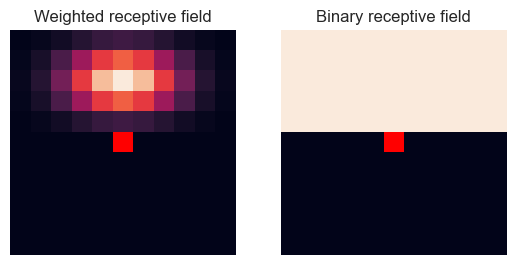

In [38]:
show_center_recep_field(inp_img, vert_img)

In [39]:
class GatedMaskedConv(nn.Module):
    def __init__(self,c_in,**kwargs):
        super().__init__()
        
        self.conv_vert = VerticalStackConvolution(c_in,c_out=2*c_in,**kwargs)
        self.conv_horiz = HorizontalStackConvolution(c_in,c_out=2*c_in,**kwargs)
        self.conv_vert_to_horiz = nn.Conv2d(2*c_in,2*c_in,kernel_size=1,**kwargs)
        self.conv_horiz_1x1 = nn.Conv2d(c_in,c_in,kernel_size=1,padding=0)
        
    def forward(self,v_stack,h_stack):
        v_stack_feat =self.conv_vert(v_stack)
        v_val,v_gate = v_stack_feat.chunk(2,dim=1)
        v_stack_out = torch.tanh(v_val)*torch.sigmoid(v_gate)
        
        h_stack_feat = self.conv_horiz(h_stack)
        h_stack_feat = h_stack_feat + self.conv_vert_to_horiz(v_stack_feat)
        
        h_val,h_gate = h_stack_feat.chunk(2,dim=1)
        h_stack_feat = torch.tanh(h_val)*torch.sigmoid(h_gate)
        h_stack_out = self.conv_horiz_1x1(h_stack_feat)
        h_stack_out = h_stack_out + h_stack
        
        return v_stack_out,h_stack_out

In [40]:
class PixelCNN(pl.LightningModule):

    def __init__(self, c_in, c_hidden):
        super().__init__()
        self.save_hyperparameters()

        # Initial convolutions skipping the center pixel
        self.conv_vstack = VerticalStackConvolution(c_in, c_hidden, mask_center=True)
        self.conv_hstack = HorizontalStackConvolution(c_in, c_hidden, mask_center=True)
        # Convolution block of PixelCNN. We use dilation instead of downscaling
        self.conv_layers = nn.ModuleList([
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=2),
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=4),
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=2),
            GatedMaskedConv(c_hidden)
        ])
        # Output classification convolution (1x1)
        self.conv_out = nn.Conv2d(c_hidden, c_in * 256, kernel_size=1, padding=0)

        self.example_input_array = train_set[0][0][None]

    def forward(self, x):
       
        x = (x.float() / 255.0) * 2 - 1

        # Initial convolutions
        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)
        # Gated Convolutions
        for layer in self.conv_layers:
            v_stack, h_stack = layer(v_stack, h_stack)
        # 1x1 classification convolution
        # Apply ELU before 1x1 convolution for non-linearity on residual connection
        out = self.conv_out(F.elu(h_stack))

        # Output dimensions: [Batch, Classes, Channels, Height, Width]
        out = out.reshape(out.shape[0], 256, out.shape[1]//256, out.shape[2], out.shape[3])
        return out

    def calc_likelihood(self, x):
        # Forward pass with bpd likelihood calculation
        pred = self.forward(x)
        nll = F.cross_entropy(pred, x, reduction='none')
        bpd = nll.mean(dim=[1,2,3]) * np.log2(np.exp(1))
        return bpd.mean()

    @torch.no_grad()
    def sample(self, img_shape, img=None):

        # Create empty image
        if img is None:
            img = torch.zeros(img_shape, dtype=torch.long).to(device) - 1
        # Generation loop
        for h in tqdm(range(img_shape[2]), leave=False):
            for w in range(img_shape[3]):
                for c in range(img_shape[1]):
                    # Skip if not to be filled (-1)
                    if (img[:,c,h,w] != -1).all().item():
                        continue
                    # For efficiency, we only have to input the upper part of the image
                    # as all other parts will be skipped by the masked convolutions anyways
                    pred = self.forward(img[:,:,:h+1,:])
                    probs = F.softmax(pred[:,:,c,h,w], dim=-1)
                    img[:,c,h,w] = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
        return img

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('train_bpd', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('val_bpd', loss)

    def test_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('test_bpd', loss)


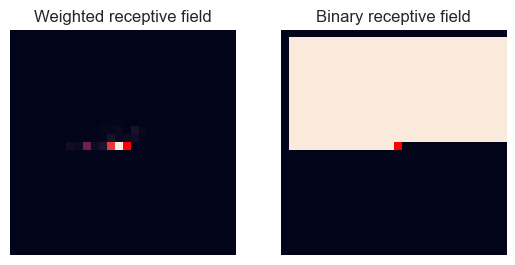

In [41]:
test_model = PixelCNN(c_in=1, c_hidden=64)
inp = torch.zeros(1,1,28,28)
inp.requires_grad_()
out = test_model(inp)
show_center_recep_field(inp, out.squeeze(dim=2))
del inp, out, test_model

In [45]:
def train_model(**kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(model_path, "PixelCNN"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=1)
    result = None    
    model = PixelCNN(**kwargs)
    trainer.fit(model, train_loader, val_loader)
    model = model.to(device)

    if result is None:
        # Test best model on validation and test set
        val_result = trainer.test(model, val_loader, verbose=False)
        test_result = trainer.test(model, test_loader, verbose=False)
        result = {"test": test_result, "val": val_result}
    return model, result

In [46]:
model, result = train_model(c_in=1, c_hidden=64)
test_res = result["test"][0]
print("Test bits per dimension: %4.3fbpd" % (test_res["test_loss"] if "test_loss" in test_res else test_res["test_bpd"]))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type                       | Params | Mode  | In sizes        | Out sizes       
--------------------------------------------------------------------------------------------------------
0 | conv_vstack | VerticalStackConvolution   | 640    | train | [1, 1, 28, 28]  | [1, 64, 28, 28] 
1 | conv_hstack | HorizontalStackConvolution | 256    | train | [1, 1, 28, 28]  | [1, 64, 28, 28] 
2 | conv_layers | ModuleList                 | 834 K  | train | ?               | ?               
3 | conv_out    | Conv2d                     | 16.6 K | train | [1, 64, 28, 28] | [1, 256, 28, 28]
--------------------------------------------------------------------------------------------------------
852 K     Trainable params
0         Non-trainable params
852 K     Total params
3.409     Total estimated model params size (MB)
55        Modules in train mode
0         Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
C:\Users\catal\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

Test bits per dimension: 1.139bpd


Seed set to 1


  0%|          | 0/28 [00:00<?, ?it/s]

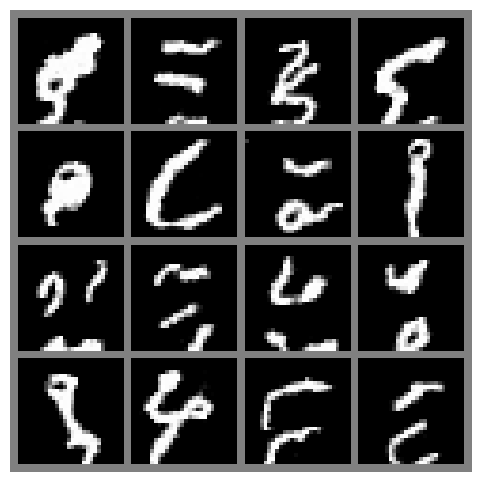

In [48]:
pl.seed_everything(1)
samples = model.sample(img_shape=(16,1,28,28))
show_imgs(samples.cpu())

In [47]:
pl.seed_everything(1)
samples = model.sample(img_shape=(8,1,64,64))
show_imgs(samples.cpu())

Seed set to 1


  0%|          | 0/64 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def autocomplete_image(img):
    # Remove lower half of the image
    img_init = img.clone()
    img_init[:,10:,:] = -1
    print("Original image and input image to sampling:")
    show_imgs([img,img_init])
    # Generate 12 example completions
    img_init = img_init.unsqueeze(dim=0).expand(12,-1,-1,-1).to(device)
    pl.seed_everything(1)
    img_generated = model.sample(img_init.shape, img_init)
    print("Autocompletion samples:")
    show_imgs(img_generated)

for i in range(1,4):
    img = train_set[i][0]
    autocomplete_image(img)